Корнилов А.И. 43 Вариант.

Цель лабораторной работы – получение навыков работы с методами классификации.
1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;
3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)
4.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);
5.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены;
6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);
7.	Заполните пропущенные значения в данных;
8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию. 
9.	Сравните кривые для классификаторов, указанных в задании, сделайте выводы.


1)	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

1) Alcohol - процентное содержание алкоголя;

2) Malic acid – содержание яблочной кислоты;

3) Ash - зольность;

4) Alcalinity of ash – содержание щелочи;

5) Magnesium – содержание магния;

6) Total phenols – общее число фенолов;

7) Flavanoids – Флавоноиды;

8) Nonflavanoid phenols - нефлаваноидные фенолы;

9) Proanthocyanins - Проантоцианы;

10)Color intensity – интенсивность цвета;

11)Hue – оттенок вина;

12)OD2 80/OD315 of diluted wines – разбавленность вина;

13)Proline – сорт вина.

2)	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
%matplotlib inline
warnings.simplefilter('ignore')

In [97]:
wine_data = pd.read_csv("wine.data.txt")
wine_data.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD2 80/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [98]:
print("До удаление дубликатов: %d" % len(wine_data))
wine_data.drop_duplicates(keep="first", inplace=True)
print("После удаление дубликатов: %d" % len(wine_data))

До удаление дубликатов: 178
После удаление дубликатов: 178


3) Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

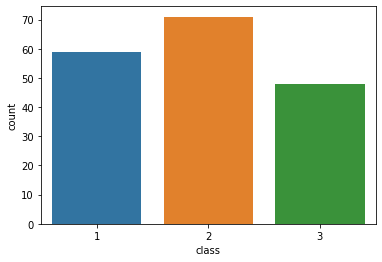

In [99]:
sns.barplot(data=pd.DataFrame({
    'count': [
        len(wine_data.loc[wine_data["class"] == 1]),
        len(wine_data.loc[wine_data["class"] == 2]),
        len(wine_data.loc[wine_data["class"] == 3]),
    ],
    'class': [
        '1',
        '2',
        '3'
    ],
}), y='count', x='class')

Вывод: Классы сбалансированны.

4) Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);

In [100]:
wine_data['class'] = wine_data['class'].apply(lambda x: str(x))
numerical_columns = [i for i in wine_data.columns if wine_data[i].dtype.name != 'object']
categorial_columns = [i for i in wine_data.columns if wine_data[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  [' Alcohol', ' Malic acid', ' Ash', ' Alcalinity of ash', ' Magnesium', ' Total phenols', ' Flavanoids', ' Nonflavanoid phenols', ' Proanthocyanins', ' Color intensity', ' Hue', ' OD2 80/OD315 of diluted wines', ' Proline']
categorial:  ['class']


In [104]:
scaler = MinMaxScaler()
wine_data[numerical_columns] = scaler.fit_transform(wine_data[numerical_columns])
wine_data.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD2 80/OD315 of diluted wines,Proline
0,1,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,1,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,1,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,1,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


5) Выполните замену категориальных признаков; выберите и обоснуйте способ замены;

In [102]:
for i in categorial_columns:
    print(i,': ', wine_data[i].unique())

class :  ['1' '2' '3']


In [107]:
# для не бинарых применим dummy-кодирование
nonbinary_columns = categorial_columns

wine_data_nonbinary = pd.get_dummies(wine_data[nonbinary_columns])
wine_data.drop(nonbinary_columns, axis=1, inplace=True)
wine_data = pd.concat([wine_data_nonbinary, wine_data] , axis=1)

print(wine_data.shape)
wine_data.head()

['class']
(178, 16)


,class_1,class_2,class_3,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD2 80/OD315 of diluted wines,Proline
0,1,0,0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,1,0,0,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,1,0,0,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,1,0,0,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,1,0,0,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


6) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);

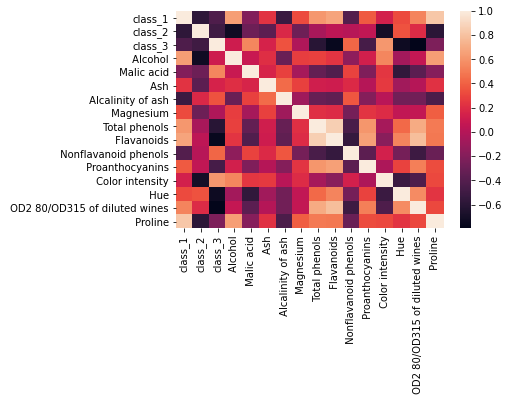

In [108]:
corr_matrix = wine_data.corr()
sns.heatmap(corr_matrix)

7) Заполните пропущенные значения в данных;

In [109]:
wine_data.count()

class_1                           178
class_2                           178
class_3                           178
 Alcohol                          178
 Malic acid                       178
 Ash                              178
 Alcalinity of ash                178
 Magnesium                        178
 Total phenols                    178
 Flavanoids                       178
 Nonflavanoid phenols             178
 Proanthocyanins                  178
 Color intensity                  178
 Hue                              178
 OD2 80/OD315 of diluted wines    178
 Proline                          178
dtype: int64

Пропуски отсутствуют.

8) Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию.

In [110]:
data_X, data_Y = wine_data.drop(columns="class_2", axis=1).values, wine_data["class_2"]
train_x, test_x, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.3)

Линейный классификатор (персептрон)

In [114]:
ppn = Perceptron()

search = GridSearchCV(estimator=ppn, param_grid={
    'alpha': np.linspace(0, 1, 20)[1:],
    'max_iter': [x for x in range(1, 50)],
}, n_jobs=-1)
search.fit(train_x, train_y)
alpha = search.best_estimator_.alpha
max_iter = search.best_estimator_.max_iter
best = search.best_score_
print(' best:', best,"\n",'alpha:', alpha,"\n", 'max_iter:', max_iter)

ppn = Perceptron(alpha=alpha, max_iter=max_iter)
ppn.fit(train_x, train_y)
ppn_predict = ppn.predict(test_x)
print(' Accuracy ppn: %.5f' % accuracy_score(test_y, ppn_predict))

 best: 1.0 
 alpha: 0.05263157894736842 
 max_iter: 1
 Accuracy ppn: 0.98148


Логический классификатор (бинарное решающее дерево)

In [118]:
dtc = DecisionTreeClassifier()
params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit (train_x, train_y)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print(' best:', best_score, "\n", 'at features number:', best_features, "\n", 'at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(train_x, train_y)
accuracy_score  = np.mean(test_y == dtc.predict(test_x))
print(' Accuracy dtc: %.5f' % accuracy_score)

 best: 0.992 
 at features number: 11 
 at depth: 11
 Test score:  0.992
 Accuracy dtc: 0.90741


9) Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

PR графики

In [123]:
def addPlotPr(prob, occupancy, label, test):
    precision, recall, _ = precision_recall_curve(test, prob[:, occupancy])
    aps = average_precision_score(test, prob[:, occupancy])
    plt.plot(recall, precision, label='%s PR (area = %f)' % (label, aps))

In [128]:
test_y_inversion = [1-y for y in test_y]

prob_dtc = dtc.predict_proba(test_x)

cppn = CalibratedClassifierCV(ppn, cv=10)
cppn.fit(train_x, train_y)
prob_ppn = cppn.predict_proba(test_x)

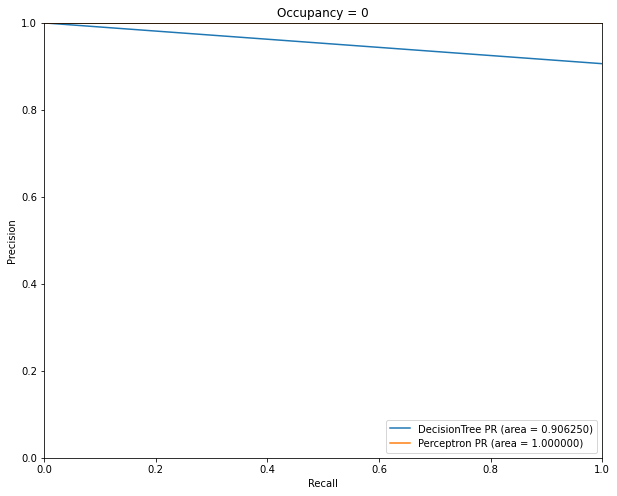

In [129]:
plt.figure(figsize=(10,8))

addPlotPr(prob_dtc, 0, 'DecisionTree', test_y_inversion)
addPlotPr(prob_ppn, 0, 'Perceptron', test_y_inversion)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Occupancy = 0')
plt.legend(loc=4, fontsize='medium')
plt.show()

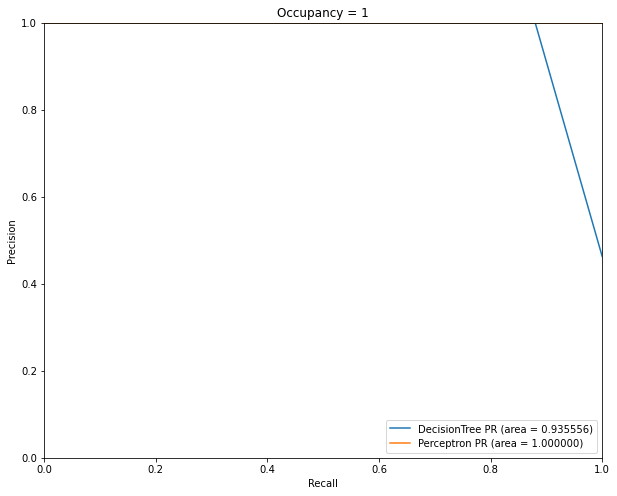

In [130]:
plt.figure(figsize=(10,8))

addPlotPr(prob_dtc, 1, 'DecisionTree', test_y)
addPlotPr(prob_ppn, 1, 'Perceptron', test_y)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Occupancy = 1')
plt.legend(loc=4, fontsize='medium')
plt.show()

ROC графики

In [131]:
def addPlotRoc0(prob, label, test):
    tpr, fpr, _ = roc_curve(test, prob[:, 0])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %f)' % (label, roc_auc)) 

def addPlotRoc1(prob, label, test):
    fpr, tpr, _ = roc_curve(test, prob[:, 1])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %f)' % (label, roc_auc))

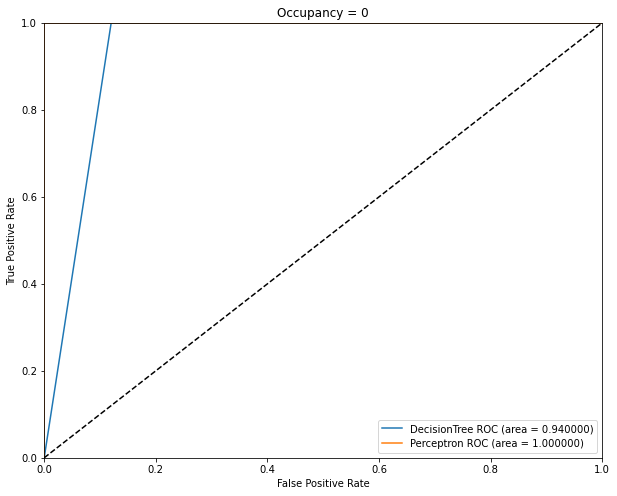

In [132]:
plt.figure(figsize=(10,8))

addPlotRoc0(prob_dtc, 'DecisionTree', test_y)
addPlotRoc0(prob_ppn, 'Perceptron', test_y)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 0')
plt.show()

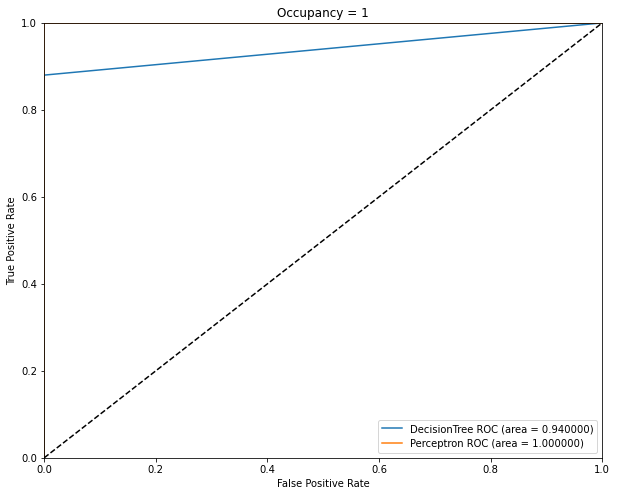

In [133]:
plt.figure(figsize=(10,8))

addPlotRoc1(prob_dtc, 'DecisionTree', test_y)
addPlotRoc1(prob_ppn, 'Perceptron', test_y)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 1')
plt.show()